In [1]:
#!/usr/bin/env python3
#import your libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder

import time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import recall_score
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import binarize
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from sklearn.tree import DecisionTreeClassifier

In [31]:
train_transaction = pd.read_csv('/Users/krahman/work/fraud_detection/data/train_transaction.csv')
train_identity = pd.read_csv('/Users/krahman/work/fraud_detection/data/train_identity.csv')
# merging dataframes 
df_raw = train_transaction.merge(train_identity, on='TransactionID', how='left')
df_train = df_raw.copy()

In [3]:
# list(df_train.columns)

In [4]:
# train_transaction.head() # KEEP

In [ ]:
# train_identity.head() # KEEP

In [ ]:
# train_transaction.info(); # KEEP

In [ ]:
# train_identity.info(); # KEEP

#### Data Quality Check

In [ ]:
# list_null = df_train.isnull().any()
# df_null = pd.DataFrame(list_null).reset_index()
# df_null

In [ ]:
# df_train.loc[:,df_train.isnull().any()]['id_34'].unique()

In [ ]:
# KEEP
# train_transaction_sum = train_transaction.duplicated().sum()
# train_identity_sum = train_identity.duplicated().sum()
# columns = train_transaction.columns
# print('Train transaction duplicates: {}\nTrain identity duplicates: {} \n'.format(train_transaction_sum, train_identity_sum))
# # print('Train feature columns:\n', list(columns))

In [ ]:
# df_train.isnull().any() # KEEP

In [ ]:
# df_train.info() # KEEP

In [ ]:
# df_train.dtypes # KEEP

#### EDA

In [ ]:
# How many transactions are in the dataset?
# df_train.shape # KEEP

In [ ]:
# What is the fraud rate of the data set?
# fraud_rate = df_train.isFraud.value_counts() / 590540
# fraud_rate  # KEEP

In [ ]:
# What is the statistical overview of the data set?
# df_train.describe() # KEEP

In [ ]:
# fraud_summary = df_train.groupby('isFraud')
# fraud_summary.mean()

In [ ]:
# fraud_summary.mean().to_csv('/Users/krahman/work/fraud_detection/saved_files/fraud_groupby.csv')

In [ ]:
# df_train.isnull().any()

### Assigning columns to specific lists (cat, num, date, etc.)

In [32]:
# dropping columns with more than 50% missing data
length_df = df_train.shape[0]/2
list_temp = []
for val in df_train.columns:
    if np.sum(df_train[val].isnull()) > length_df:
        list_temp.append(val)   
df_train = df_train.drop(list_temp, axis=1)

###################################
# c is num, ex, how many addresses associated with card
col_c = [c for c in df_train.columns if c.startswith('C') and (len(c)==2 or len(c)==3)]
# d is num, time/days between transactions
col_d = [d for d in df_train.columns if d.startswith('D') and (len(d)==2 or len(d)==3)]
# m is date of transaction
col_m = [m for m in df_train.columns if m.startswith('M') and (len(m)==2 or len(m)==3)]
# v is num, features created by vesta such as ranking, counting. entity relationships, etc. 
col_v = [v for v in df_train.columns if v.startswith('V') and (len(v)==2 or len(v)==3 or len(v)==4)]
# i is identity information like network and digital signature associated with transaction
col_i = [i for i in df_train.columns if i.startswith('id_') and len(i)==5]
# ca is cat, card information such as card type, etc. 
col_card = [ca for ca in df_train.columns if ca.startswith('card')]
# D = time elapsed between each transaction, card = card information, C = counting, ie how many addresses 
# associated with card, M=True/False, V created features on ranking, counting, etc. 

# column id and target
col_id = ['TransactionID']
col_target = 'isFraud'

# converting categorical columns with numerical values to string types.
col_cat_to_obj = ['addr1','addr2','card1','card2', 'card3', 'card5']
for val in col_cat_to_obj:
    df_train[val] = df_train[val].astype(str)

# categorical columns
col_cat = ['addr1','addr2','ProductCD',"P_emaildomain"] + col_card + col_m

# C counter, D is time elapsed between transactions, V feature engineered variables by firm
col_num = ['TransactionAmt'] + col_c + col_d + col_v 
col_num.append(col_target)

# figure out how to handle this. What do these dates mean? Do certain dates have more fraud occurences?
col_date = ['TransactionDT'] 

# boolean columns. convert via dummy variable. We dont know if true/false is better than one or the other. 
# col_bool = col_m

# confirming all columns are accounted for
print('Total columns: ' + str(len(col_cat + col_num + col_date + col_id + col_i)))

# columns removed dist1, dist2, R_emaildomain, DeviceInfo, DeviceType 

Total columns: 220


In [ ]:
class Preprocessing:
    def __init__(self):
        '''initialize variables and column names for null dataframe'''
        self.df_train = df_train.copy()
        self.list_col = []
        self.list_total = []
        self.dict_unique = {}
        self.list_datatype = []
        self.list_unique_val = []
        self.list_mode_count = []
        self.list_mode_value = []
        self.list_mode_count_perc = []
        self.list_unique_total = []
        self.list_unique_first_10 = []
        self.column_names = ['col_name', 'total_null', 'datatype', 'total_unique',
                             'mode_value', 'mode_count', 'mode_percentage']

    def missing_values(self):
        '''check for null values and add to null dataframe if more than 0 nulls exist'''
        for val in df_train.columns:
            total_null = np.sum(df_train[val].isnull())
            if total_null > 0:
                self.list_col.append(val)
                self.list_total.append(total_null)
                self.list_datatype.append(df_train[val].dtype)
                self.list_unique_total.append(len(df_train[val].unique()))
                self.list_unique_val.append(df_train[val].unique())
                self.list_mode_value.append(df_train[val].mode()[0])
#                 self.list_mode_value.append('MISSING')

                val_counts = max(df_train[val].value_counts())
                self.list_mode_count.append(val_counts)
                self.list_mode_count_perc.append(val_counts/len(df_train))
                val_unique = df_train[val].unique()
                self._create_dict(val_unique, df_train, val)
        df_null_info = self._create_dataframe()
        df_null_info = self._create_df_unique(df_null_info)
        self._summary(df_null_info)
        self._fillna(df_null_info)
        return df_null_info
    
    def _create_dict(self, val_unique, df_train, val):
        '''create dictionary of unique values for each column'''
        if (len(val_unique) > 99) and isinstance(df_train[val], object):  
            self.dict_unique.update([(val,0)])
        if (len(val_unique) > 99) and not isinstance(df_train[val], object):
            self.dict_unique.update([(val,0)])
        if len(val_unique) < 100:
            self.dict_unique.update([(val, val_unique)])

    def _create_dataframe(self):
        '''create main dataframe'''
        df_null_info = pd.DataFrame()
        counter = -1
        for list_val in [self.list_col, self.list_total, self.list_datatype, self.list_unique_total,
                        self.list_mode_value, self.list_mode_count, self.list_mode_count_perc]:
            counter = counter + 1
            col_title = self.column_names[counter]
            df = pd.DataFrame(list_val, columns=[col_title])
            df_null_info = pd.concat([df_null_info, df], axis=1)
        return df_null_info
    
    def _summary(self, df_null_info):
        val = df_null_info.shape[0]
        print('There were ' + str(val) + ' columns with null values.')
    
    def _create_df_unique(self, df_null_info):
        '''create unique values dataframe'''
        series_unique = pd.Series(self.dict_unique)
        df_unique = pd.DataFrame(series_unique).reset_index()
        df_unique = df_unique.rename(columns={'index':'col_name', 0:'unique'})
        df_null_info = df_null_info.merge(df_unique, how='left', 
                                          left_on='col_name', right_on='col_name')
        df_null_info.to_csv('/Users/krahman/work/fraud_detection/saved_files/df_null_info.csv')
        return df_null_info
    
    def _fillna(self, df_null_info):
        '''fill null values of df_train with mode'''
        total_null_columns = sum(np.sum(self.df_train.isnull()))
        if total_null_columns > 0:
            for val in df_null_info.col_name:
                val_mode = self.df_train[val].mode()[0]
                self.df_train[val] = self.df_train[val].fillna(val_mode)
#                 print("fillna," + str(val))

#                 self.df_train[val] = self.df_train[val].fillna('MISSING')
    
    def impute_features(self):
        df_temp = pp.df_train
        for val in col_cat:
            total_unique_val = pp.df_train[val].unique().shape[0]
            if len(df_temp[val].unique()) < 60:
                print('dummies encoded: ' + str(val) + ' unique ' + str(total_unique_val))
                df_dumm = pd.get_dummies(df_temp[val], prefix=val, drop_first=True)
                df_temp = df_temp.drop(val,axis=1)
                df_temp = pd.concat([df_temp, df_dumm], axis=1)
            else:
                le = LabelEncoder()
                df_temp[val] = le.fit_transform(df_temp[val])
                print('label encoded: ' + str(val) + ' unique ' + str(total_unique_val))
        print('new dataframe shape:' + str(df_temp.shape))
        return df_temp

pp = Preprocessing()
df_null_info = pp.missing_values()
# df_null_info

# determine what to do with columns that have too many unique values... obviously.. types of solutions
# would be to put "MISSING" for those that dont have an email address... but you will need to evaluate 
# and make instead a counter of unique values, then append that and look at the CSV via google sheets. use 
# something like the code below 

# TEST: test imputing with missing instead of mode to see if we have improvements in model 

In [34]:
pp.df_train = pp.impute_features()
pp.df_train.to_csv('/Users/krahman/work/fraud_detection/saved_files/df_imputed.csv')

label encoded: addr1 unique 333
label encoded: addr2 unique 75
dummies encoded: ProductCD unique 5
dummies encoded: P_emaildomain unique 59
label encoded: card1 unique 13553
label encoded: card2 unique 501
label encoded: card3 unique 115
dummies encoded: card4 unique 4
label encoded: card5 unique 120
dummies encoded: card6 unique 4
dummies encoded: M1 unique 2
dummies encoded: M2 unique 2
dummies encoded: M3 unique 2
dummies encoded: M4 unique 3
dummies encoded: M6 unique 2
new dataframe shape:(590540, 285)


In [35]:
# ['addr1', 'addr2', 'ProductCD', 'P_emaildomain', 'card1', 'card2', 'card3', 'card4', 
#  'card5', 'card6', 'M1', 'M2', 'M3', 'M4', 'M6']

In [84]:
df_features = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/df_imputed.csv')
df_features = df_features.drop('Unnamed: 0', axis=1)

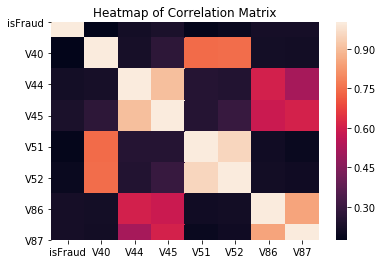

,isFraud,V40,V44,V45,V51,V52,V86,V87
isFraud,1.000000,0.174672,0.217870,0.235436,0.182007,0.195492,0.222343,0.221568
V40,0.174672,1.000000,0.225232,0.271469,0.744831,0.745758,0.217055,0.213533
V44,0.217870,0.225232,1.000000,0.905537,0.257145,0.251881,0.604776,0.515480
V45,0.235436,0.271469,0.905537,1.000000,0.257400,0.296102,0.585396,0.608788
V51,0.182007,0.744831,0.257145,0.257400,1.000000,0.954315,0.212453,0.196567
V52,0.195492,0.745758,0.251881,0.296102,0.954315,1.000000,0.215183,0.207535
V86,0.222343,0.217055,0.604776,0.585396,0.212453,0.215183,1.000000,0.850021
V87,0.221568,0.213533,0.515480,0.608788,0.196567,0.207535,0.850021,1.000000


In [37]:
fraud_summary = df_features.groupby('isFraud')
fraud_summary.mean().to_csv('/Users/krahman/work/fraud_detection/saved_files/fraud_summary.csv')

corr = df_features.corr()
corr.to_csv('/Users/krahman/work/fraud_detection/saved_files/corr_matrix.csv')
corr2 = corr[corr['isFraud']>.17]
corr2 = corr2.loc[:,corr2.index]

sns.heatmap(corr2,
           xticklabels=corr2.columns.values,
           yticklabels=corr2.columns.values)
plt.title('Heatmap of Correlation Matrix')
plt.show()
corr2

In [ ]:
# plt.figure(figsize=(14,4))
# sns.barplot(x='V44', y='V44', hue='isFraud', data=df_train)
# plt.show()

# sns.lmplot(x='addr1', y='addr2', data=df_features,
#            fit_reg=False, hue='isFraud')
# plt.show()

# sns.distplot(df_features.addr1)
# plt.show()

# plt.scatter(X.card1, y)
# sns.regplot(x='card5_237.0', y='isFraud', data=pp.df_train, logistic=True, color='b')

## Splitting features dataframe

In [ ]:
# # create features, target and split the dataframe
# X = pp.df_train.drop(col_target, axis=1)
# X = X.drop(col_id, axis=1)
# y = pp.df_train[col_target]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=42)

In [ ]:
# X = df_features.drop(col_target, axis=1)
# X = X.drop(col_id, axis=1)
# y = df_features[col_target]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

### Test Dropping Features On Base Model

In [ ]:
###########
# y_test = pp.df_train[col_target] #.rename(columns=['isFraud'])
# y_test = pd.Series(y_test)
# y_test

In [ ]:
# # Testing dropping columns
# model_lr_results = pd.DataFrame()
# model_recall = []
# model_precision = []
# model_auc_score = []

# for col in ['addr1', 'addr2', 'P_emaildomain', 'card1', 'card2', 'card3', 'card5']:
#     print('Dropping: ', col)
#     X_drop = X.drop(col, axis=1)
# #     X_drop = X_drop.loc[:10000,:]
#     y_drop = y#[:10001]
    
#     scaled_X = StandardScaler().fit_transform(X_drop)
#     # pca
#     pca = PCA()
#     pcomponents = pca.fit_transform(scaled_X)
#     X_pca = pd.DataFrame(data=pcomponents)
#     # split
#     X_train2, X_test2, y_train2, y_test2 = train_test_split(X_pca, y_drop, test_size=0.1, random_state=42)
#     # smote
#     sm = SMOTE(random_state=42, ratio=1.0, n_jobs=-1)
#     X_train_res, y_train_res = sm.fit_sample(X_train2, y_train2)
#     # model fit
#     model_lr_pca = LogisticRegression(random_state=42)
#     model_lr_pca.fit(X_train_res, y_train_res)
#     # predict
#     y_pred_prob = model_lr_pca.predict_proba(X_pca)
#     y_pred_class = binarize(y_pred_prob, 0.5)[:,1]
#     # scoring
#     model_recall.append(recall_score(y_drop, y_pred_class))
#     model_precision.append(precision_score(y_drop, y_pred_class))
#     model_auc_score.append(roc_auc_score(y_drop, y_pred_prob[:,1]))
#     print(confusion_matrix(y_drop, y_pred_class))
#     print(classification_report(y_drop, y_pred_class))
#     print('AUC: ', roc_auc_score(y_drop, y_pred_prob[:,1]))

# model_recall = pd.Series(model_recall, name='recall')
# model_precision = pd.Series(model_precision, name='precision')
# model_auc_score = pd.Series(model_auc_score, name='auc_score')
# model_results_final = pd.concat([model_auc_score, model_recall, model_precision],axis=1)
# model_results_final

# # it's apparent that label encoding on some of these don't really matter and if we drop them.. it doesn't really
# # matter.. 
# # dropping these columns has little impact with logistic regression.. 

# # tune logistic regression

In [ ]:
# ### DELETE

# class Results():
#     def __init__(self):
#         self.model_lr_results = pd.DataFrame()
#         self.model_recall = []
#         self.model_precision = []
# #         self.model_auc_score = []
        
#     def _score(self, y_true, y_pred):
#         self.model_recall.append(recall_score(y_true, y_pred))
#         self.model_precision.append(precision_score(y_true, y_pred))
#         self._create_series()
# #         self.model_auc_score.append(roc_auc_score(y_true, y_pred[:,1]))

#     def _create_series(self):
#         model_recall = pd.Series(self.model_recall, name='recall')
#         model_precision = pd.Series(self.model_precision, name='precision')
# #         model_auc_score = pd.Series(self.model_auc_score, name='auc_score')
#         model_results_final = pd.concat([model_recall, model_precision],axis=1)
#         return model_results_final

# df_temp = pd.DataFrame(pca.explained_variance_ratio_)
# df_temp[0:20]
# pd.DataFrame(pca.components_, columns=list(X_temp.columns), index=range(0,225))
# pca.components_

#### Applying PCA (2 components)

In [ ]:
# # standardizing our data, which is required for PCA.
# scaled_X = StandardScaler().fit_transform(X)

# # PCA instantiate and fit 
# pca = PCA(n_components=2)
# pcomponents = pca.fit_transform(scaled_X)
# X_pca = pd.DataFrame(data = pcomponents, columns=['PC1','PC2'])
# print(X_pca.shape)
# X_pca.head()

# # two principal components scatter plot
# plt.figure(figsize=(8,6))
# plt.scatter(X_pca['PC1'], X_pca['PC2'], c=y['isFraud'])
# plt.xlabel('First principal component')
# plt.ylabel('Second principal component')

# # explaining vaariance
# print('Variance ratio:')
# print(pca.explained_variance_ratio_)
# # interpreting principal components
# print('\nPrincipal components explained:')
# pd.DataFrame(pca.components_, columns=list(X.columns), index=('PC1', 'PC2'))

#### Applying PCA to all features (all components)

In [ ]:
# pca2 = PCA().fit(scaled_X)
# plt.plot(np.cumsum(pca2.explained_variance_ratio_))
# plt.xlabel('Number of Components')
# plt.ylabel('Variance (%)')
# plt.title('Credit Card Fraud Explained Variance')
# plt.show()

#### Model w/ SMOTE only - base model

In [ ]:
# X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.1, random_state=42)

# # Apply SMOTE
# sm = SMOTE(random_state=42, ratio=1.0, n_jobs=-1)
# X_train_res, y_train_res = sm.fit_sample(X_train1, y_train1)

# model_lr = LogisticRegression(random_state=42)
# model_lr.fit(X_train_res, y_train_res) 

# # predicting on test set w/o PCA
# print("Predicting using only SMOTE (and w/o PCA)\n")
# y_pred_test1 = model_lr.predict(X_test1)
# print("Test set:")
# print("Validation results")
# print(model_lr.score(X_test1, y_test1))
# print(recall_score(y_test1, y_pred_test1))
# print("\nConfusion Matrix")
# print(confusion_matrix(y_test1, y_pred_test1))
# print('\nClassification Report:\n')
# print(classification_report(y_test1, y_pred_test1))

# # predicting on original dataset
# print("Whole dataset:")
# y_pred = model_lr.predict(X)
# print("\nTest Results")
# print(model_lr.score(X, y))
# print(recall_score(y, y_pred))
# print("\nConfusion Matrix")
# print(confusion_matrix(y, y_pred))
# print('\nClassification Report:\n')
# print(classification_report(y, y_pred))

## Logistic Regression w/PCA  w/SMOTE

### EDA

In [ ]:
# sns.lmplot(x='addr1', y='addr2', data=df_features,
#            fit_reg=False, hue='isFraud')
# plt.title('addr1 versus addr2')
# plt.show()

# sns.distplot(df_features.addr1)
# plt.title('Addr1 Distribution')
# plt.show()

In [ ]:
# # EDA Email Class
# # P_emaildomain
# # list(df_train.columns)
# # df_train.P_emaildomain.unique()
# list_perc = []
# list_fraud_count = []
# list_non_fraud_count = []
# for val in df_train.P_emaildomain.unique():
#     non_fraud_count = df_train[(df_train.P_emaildomain==val) & (df_train.isFraud==0)].shape[0]
#     fraud_count = df_train[(df_train.P_emaildomain==val) & (df_train.isFraud==1)].shape[0]
    
#     list_perc.append(fraud_count/non_fraud_count)
    
#     list_fraud_count.append(fraud_count)
#     list_non_fraud_count.append(non_fraud_count)
    
# col_email = pd.Series(df_train.P_emaildomain.unique(), name='email')
# col_perc = pd.Series(list_perc, name='fraud_perc')
# col_fraud_count = pd.Series(list_fraud_count, name='fraud_count')
# col_non_fraud_count = pd.Series(list_non_fraud_count, name='non_fraud_count')

# # col_perc
# df_email_fe = pd.concat([col_email, col_perc, col_fraud_count, col_non_fraud_count], axis=1)
# # df_email_fe
# # df_train[(df_train.P_emaildomain=='outlook.com') & (df_train.isFraud==1)].shape[0]


In [ ]:
# Hypothesis: less occurring email domains are more likely to have higher fraud_perc because they are 
# perhaps an email provider with less resources. The card that the holder has attached to certain email
# addresses puts them at higher risk for fraud. 

In [ ]:
# df_raw.dtypes
# df_features = df_\\

### Feature Engineering Class

In [212]:
# df_features['P_emaildomain_copy'] = df_train['P_emaildomain']
class FeatureEngineering():
    '''create engineered features for columns without ordinal values'''
    def __init__(self):
        self.list_fraud_perc = []
        self.df_feat = df_features.copy()
        self.df_raw = df_raw.copy()
        self.len_df_feat = self.df_feat.shape[0]
#         self.list_new_feat = [] # delete redundant
        self.dict_all_feat = {}
        self.new_col = []
        
    def create_feature(self, col):
        '''creates correllated ratio to target column'''
        df_feat = df_features.copy()
        
        for col in df_temp_fe.columns:
            df_temp_fe2 = pd.concat([df_features, df_temp_fe[col]], axis=1)
            df_feat = self._calculate_fraud_perc(col, df_feat) 
            df_feat = self._map_col(col, df_feat)
            df_feat = self._create_ratio(df_feat)
            df_feat = df_feat.drop(col, axis=1)
        
#         df_feat = self._calculate_fraud_perc(col, df_feat) 
# #         self.list_new_feat.append(col_val + '_fe') ### delete?
#         df_feat = self._map_col(col, df_feat)
#         df_feat = self._create_ratio(df_feat)
#         df_feat = df_feat.drop(col, axis=1)
# #         print(list(df_feat.columns))

        return df_feat

    def aggregate_features(self, list_col, val_aggreg):
        for col in list_col:
            df_groupby = self.df_raw.groupby(col).mean()
            dict_aggreg_col = df_groupby[[val_aggreg]].to_dict()
            self.df_feat[col + '_fe'] = self.df_raw[col].map(dict_aggreg_col['TransactionAmt'])
            col_mode = self.df_feat[col + '_fe'].mode()[0]
            self.df_feat[col + '_fe'] = self.df_feat[col + '_fe'].fillna(col_mode)

    def _calculate_fraud_perc(self, col_val, df_feat):
        '''calculate fraud percentage for each column'''
        list_perc = []
        dict_feat = {}
        unique_col_values = df_feat[col_val].unique()
        for val in unique_col_values:
            fraud_total = df_feat[(df_feat[col_val]==val) 
                                & (df_feat[col_target]==1)].shape[0]
            non_fraud_total = df_feat[(df_feat[col_val]==val) 
                                & (df_feat[col_target]==0)].shape[0]
            if (non_fraud_total==0):
                list_perc.append(0)
            else: 
                list_perc.append(fraud_total/non_fraud_total)
        self._create_dict(col_val, list_perc, unique_col_values) # call _create_dict 
        return df_feat

    def _create_dict(self, col_val, list_perc, unique_col_values):
        '''create dictionary for original values to new fraud percent values'''
        col_name = col_val + '_fraud_perc'
        series_perc = pd.Series(list_perc, name=col_name)
        series_col = pd.Series(unique_col_values, name=col_val)
        df_feat = pd.concat([series_col, series_perc], axis=1)
        df_feat = df_feat.sort_values(col_name, ascending=False) 
        dict_feat = df_feat.set_index(col_val).to_dict()
        self.dict_all_feat.update(dict_feat)

    def _map_col(self, col, df_feat):
        '''map dictionary values to new features'''
        dict_keys = self.dict_all_feat.keys()
        for val in dict_keys:
            df_feat[col + '_fe'] = df_feat[col].map(self.dict_all_feat[val])
            self.new_col.append(col + '_fe')
        return df_feat
            
    def _create_ratio(self, df_feat):
        '''finalize new features with ranking values'''
        for val in self.new_col:
#             print(val) ### delete
            col_min_val = df_feat[df_feat[val] > 0][val].min()
            df_feat[val] = df_feat[val]/col_min_val
        self.new_col = []
        return df_feat
#             

# list_col = ['addr1', 'addr2', 'card1', 'card2', 'card3', 'card5', 'P_emaildomain_copy']
# list_col = ['addr1'] # needed for instantiating fe class.
fe = FeatureEngineering()



In [208]:
# list_col = ['TransactionAmt']#, 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2']

In [224]:
class Model():
    def __init__(self, bool_smote):
#         X_train, self.X_test, y_train, self.y_test = self._create_dataframe(df_features)
#         self.X_train, self.y_train = self._apply_smote(bool_smote, X_train, y_train)
        self.col_fe = []
        
    def _create_dataframe(self, df_feat):
        '''create and splitting dataframe'''
        X = df_feat.drop(col_target, axis=1)
        X = X.drop(col_id, axis=1)
        y = df_feat[col_target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                            test_size=0.1, 
                                                            random_state=42)
        return X_train, X_test, y_train, y_test

    def feature_testing(self, list_feat):
        '''testing and scoring new potential features'''
        if list_feat:
            for col in list_feat:
                self.col_fe = col
                if col in df_features.columns:
                    df_feat = fe.create_feature(col)
#                     df_feat = df_feat[0:1000] ### DELETE
                    X_train, X_test, y_train, y_test = self._create_dataframe(df_feat) 
                    X_train, y_train = self._apply_smote(True, X_train, y_train)
                    model = LogisticRegression(random_state=42, n_jobs=-1)
                    self.add_model(model, X_train, y_train, X_test, y_test) # also handles scoring
                else:
                    print("\nColumn", col,"does not exist in dataframe.\n")
            self.col_fe = []

    def _apply_smote(self, bool_smote, X_train, y_train):
        '''applying smote to split training set'''
        if bool_smote:
            sm = SMOTE(random_state=42, ratio=1.0, n_jobs=-1) # SMOTE
            X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
            return X_train_res, y_train_res
        else:
            return X_train, y_train
        
    def add_model(self, temp_model, X_train, y_train, X_test, y_test):        
        '''adding and scoring model'''
        model = temp_model
        start_time = time.time()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        elapsed_time = (time.time() - start_time) / 60
        self._score_model(y_pred, y_test, elapsed_time)
        
    def _score_model(self, y_pred, y_test, elapsed_time):      
        '''creating dataframe with score results'''
        col_recall = pd.Series(recall_score(y_test, y_pred), name='recall')
        col_precision = pd.Series(precision_score(y_test, y_pred), name='precision')
        col_time = pd.Series(elapsed_time, name='time_elapsed (min)')
        df_conf_matrix = self._confusion_matrix(y_test, y_pred)
        df_temp = pd.concat([col_recall, col_precision, df_conf_matrix, col_time], axis=1)
        
        if self.col_fe:
            print("Creating new feature from", self.col_fe)
            col_fe = pd.Series(self.col_fe, name='feat_tested')
            df_temp = pd.concat([col_fe, df_temp], axis=1)
            
        df_scores = self._read_create_file(df_temp)
        self._save_results(df_scores, df_temp, y_test, y_pred)
        
    def _read_create_file(self, df_temp):
        '''reading or creating df_scores file'''
        try: 
            df_scores = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/df_scores.csv')
            df_scores = df_scores.drop('Unnamed: 0', axis=1)
        except:
            print("\nCreating df_scores.csv file.") 
            df_scores = df_temp
        return df_scores
            
    def _save_results(self, df_scores, df_temp, y_test, y_pred):
        '''printing scores for new features'''            
        df_scores = pd.concat([df_scores, df_temp], axis=0)
        df_scores.to_csv('/Users/krahman/work/fraud_detection/saved_files/df_scores.csv')
        classif_report = classification_report(y_test, y_pred)
        print(classif_report)
        print('printing df_scores...\n', df_scores.tail(5))
        file_summary = open('/Users/krahman/work/fraud_detection/saved_files/df_scores_summary.txt', "r+")
        file_summary.write(self.col_fe)
        file_summary.write(classif_report)
        file_summary.close()
        
    def _confusion_matrix(self, y_test, y_pred):
        '''creating confusion matrix dataframe'''
        df_conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred))
        val_tp = pd.Series(df_conf_matrix[0][0], name='tp')
        val_fn = pd.Series(df_conf_matrix[0][1], name='fn')
        val_fp = pd.Series(df_conf_matrix[1][0], name='fp')
        val_tn = pd.Series(df_conf_matrix[1][1], name='tn')
        return pd.concat([val_fn, val_fp, val_tp, val_tn], axis=1)
        
model = Model(bool_smote=True)      
# model.add_model(LogisticRegression(random_state=42, n_jobs=-1))
# model.feature_testing(list_feat=['addr1', 'addr2,', 'card2'])

# model.feature_testing(list_feat=['addr1', 'addr2', 'card1', 'card2', 'card3', 'card5',
#  'card2', 'C4', 'C1', 'V317', 'ProductCD', 'V294', 'V279', 'C14', 'card6', 'V306', 'V69', 'D1','D2',
#  'D3','D4','D10','D11','D15'])



model.feature_testing(list_feat=['card2', 'C4', 'C1', 'V317', 'V294', 'V279', 
                        'C14', 'card6', 'V306', 'V69', 'D1','D2', 'D3','D4','D10','D11','D15'])
# GOOD FEATURES: ['addr1', 'card2', 'card3', 'card5', 'C1', 'V317', 
#                 'V279', 'V294', 'C14', 'V306', 'D2', 'D3', 'D10']
                                 
#  list_feat = ['days_7',
#  'time_days_7','time_days_14','time_days_21','time_days_30','time_days_45','time_days_60','time_days_90',
#  'time_days_12','minutes_lapsed','hours_lapsed','seconds_lapsed', 'p_email_domain_copy', 'ProductCD']


# there after, we can decide on our feature set and move on with the project. We need to add SVM and DT in our
# model class. Then we need to tune the models. we need to create features for this. 

# NEXT, run all features, then test to see what happens if we don't drop the column paired with each new feature
# then create method that creates time lapsed methods... we also need to test without dropping columns...

# we still need to test these 'ProductCD', 'card6', 'P_emaildomain_copy'

# NEXT, review the results of not dropping. 
# some of these columms should not be dropped... Most of them should not be dropped..
# we need to test without dropping.. but we keep getting the same score. 



Creating new feature from card2
              precision    recall  f1-score   support

           0       0.98      0.65      0.78     56945
           1       0.07      0.72      0.13      2109

    accuracy                           0.65     59054
   macro avg       0.53      0.68      0.45     59054
weighted avg       0.95      0.65      0.76     59054

printing df_scores...
     feat_tested    recall  precision   fn     fp     tp    tn  \
536       card1  0.711712   0.084118  608  16343  40602  1501   
537       card2  0.720247   0.070052  590  20165  36780  1519   
538       card3  0.738739   0.060043  551  24390  32555  1558   
539       card5  0.738739   0.059339  551  24698  32247  1558   
0         card2  0.720247   0.070052  590  20165  36780  1519   

     time_elapsed (min)  
536            3.294828  
537            3.457456  
538            3.500424  
539            3.619894  
0              4.987315  
Creating new feature from C4
              precision    recall  f1-scor

Creating new feature from D1
              precision    recall  f1-score   support

           0       0.98      0.60      0.75     56945
           1       0.06      0.71      0.11      2109

    accuracy                           0.61     59054
   macro avg       0.52      0.66      0.43     59054
weighted avg       0.95      0.61      0.72     59054

printing df_scores...
     feat_tested    recall  precision   fn     fp     tp    tn  \
545        V279  0.732101   0.058992  565  24629  32316  1544   
546         C14  0.757705   0.059956  511  25055  31890  1598   
547        V306  0.732575   0.061723  564  23486  33459  1545   
548         V69  0.712186   0.061785  607  22808  34137  1502   
0            D1  0.709341   0.062113  613  22589  34356  1496   

     time_elapsed (min)  
545            1.150144  
546            2.036437  
547            3.428800  
548            3.744155  
0              3.203725  
Creating new feature from D2
              precision    recall  f1-score  

In [230]:
df_temp_fe = df_features[['TransactionDT']].copy()
df_temp_fe['time_delta'] = 0
len_df_temp_fe = df_temp_fe.shape[0]

for i in range(1,len(df_temp_fe['TransactionDT'][0:len_df_temp_fe])):
    val_time_1 = df_temp_fe.loc[i - 1, 'TransactionDT']
    val_time_2 = df_temp_fe.loc[i, 'TransactionDT']
    val_time_delta = val_time_2 - val_time_1
    df_temp_fe.loc[i, 'time_delta'] = val_time_delta

df_temp_fe['days_lapsed_7'] = df_temp_fe['time_delta']/7
df_temp_fe['days_lapsed_14'] = df_temp_fe['time_delta']/14
df_temp_fe['days_lapsed_21'] = df_temp_fe['time_delta']/21
df_temp_fe['days_lapsed_30'] = df_temp_fe['time_delta']/30
df_temp_fe['days_lapsed_45'] = df_temp_fe['time_delta']/45
df_temp_fe['days_lapsed_60'] = df_temp_fe['time_delta']/60
df_temp_fe['days_lapsed_90'] = df_temp_fe['time_delta']/90
df_temp_fe['days_lapsed_365'] = df_temp_fe['time_delta']/365

# we need to test these additional columns...
df_temp_fe['s_minutes_lapsed'] = df_temp_fe['time_delta']/60 # minutes
df_temp_fe['s_hours_lapsed'] = df_temp_fe['time_delta']/3600 # hours
df_temp_fe['s_days_lapsed_1'] = df_temp_fe['time_delta']/86400
df_temp_fe['s_days_lapsed_7'] = df_temp_fe['time_delta']/604800
df_temp_fe['s_days_lapsed_14'] = df_temp_fe['time_delta']/1209600
df_temp_fe['s_days_lapsed_30'] = df_temp_fe['time_delta']/2592000
df_temp_fe['s_days_lapsed_90'] = df_temp_fe['time_delta']/7776000
df_temp_fe['s_days_lapsed_180'] = df_temp_fe['time_delta']/15552000

df_temp_fe = df_temp_fe.drop(['TransactionDT', 'time_delta'],axis=1)

In [ ]:
for col in df_temp_fe.columns:
    df_temp_fe2 = pd.concat([df_features,df_temp_fe[col]], axis=1)

In [223]:
df_features

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,card4_visa,card6_credit,card6_debit,card6_debit or credit,M1_T,M2_T,M3_T,M4_M1,M4_M2,M6_T
0,2987000,0,86400,68.50,3417,500,42,38,166,65,...,0,1,0,0,1,1,1,0,1,1
1,2987001,0,86401,29.00,7922,303,42,2,173,65,...,0,1,0,0,1,1,1,0,0,1
2,2987002,0,86469,59.00,9383,389,42,58,178,65,...,1,0,1,0,1,1,1,0,0,0
3,2987003,0,86499,50.00,6991,466,42,14,282,65,...,0,0,1,0,1,1,1,0,0,0
4,2987004,0,86506,50.00,9262,413,42,2,241,65,...,0,1,0,0,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,10855,500,42,108,132,65,...,1,0,1,0,1,1,1,0,0,0
590536,3577536,0,15811049,39.50,390,124,42,106,78,65,...,0,0,1,0,1,0,0,0,0,1
590537,3577537,0,15811079,30.95,1782,494,42,106,98,65,...,0,0,1,0,1,0,0,0,0,1
590538,3577538,0,15811088,117.00,11847,380,42,106,219,65,...,0,0,1,0,1,1,1,0,0,1


In [195]:
# df_features = df_features.drop(['days_7', 'time_days_7', 'time_days_14', 'time_days_21', 'time_days_30', 'time_days_45', 'time_days_60', 'time_days_90', 'time_days_12', 'minutes_lapsed', 'hours_lapsed', 'seconds_lapsed'],axis=1)
# print(list(df_features.columns))

In [228]:
df_temp_read = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/df_scores.csv')
df_temp_read[len(df_temp_read)-40:]

,Unnamed: 0,feat_tested,recall,precision,fn,fp,tp,tn,time_elapsed (min)
516,516,addr2,0.000000,0.000000,0,13,87,0,0.008696
517,517,card1,0.000000,0.000000,0,13,87,0,0.008569
518,518,card2,0.000000,0.000000,0,13,87,0,0.008856
519,519,card3,0.000000,0.000000,0,13,87,0,0.014285
520,520,addr1,0.000000,0.000000,0,12,88,0,0.008619
521,521,addr2,0.000000,0.000000,0,11,89,0,0.008338
522,522,addr1,0.000000,0.000000,0,12,88,0,0.014601
523,523,addr2,0.000000,0.000000,0,11,89,0,0.009156
524,524,addr1,0.000000,0.000000,0,11,89,0,0.008065
525,525,addr2,0.000000,0.000000,0,15,85,0,0.013202


In [129]:
pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/df_scores.csv')

,Unnamed: 0,feat_tested,recall,precision,fn,fp,tp,tn,time_elapsed (min)
0,0,addr1,0.824087,0.055005,371,29859,27086,1738,2.093689
1,1,addr2,0.720721,0.060584,589,23569,33376,1520,2.786479
2,2,card1,0.711712,0.084118,608,16343,40602,1501,2.437131
3,3,card2,0.749170,0.060321,529,24613,32332,1580,3.112451
4,4,card3,0.738739,0.060043,551,24390,32555,1558,2.850517
5,5,card5,0.738739,0.059339,551,24698,32247,1558,2.149401
6,6,addr1,0.000000,0.000000,0,7,93,0,0.008121
7,7,addr1,0.000000,0.000000,0,7,93,0,0.007413
8,8,addr1,0.000000,0.000000,0,7,93,0,0.010607
9,9,addr1,0.000000,0.000000,0,12,88,0,0.018702


In [93]:
############################


# for val in 

df_temp = fe.df_feat[['TransactionDT']]
df_temp['time_delta'] = 0
len_df_temp = df_temp.shape[0]
for i in range(1,len(df_temp['TransactionDT'][0:len_df_temp])):
    val_time_1 = df_temp.loc[i - 1, 'TransactionDT']
    val_time_2 = df_temp.loc[i, 'TransactionDT']
    val_time_delta = val_time_2 - val_time_1
    df_temp.loc[i, 'time_delta'] = val_time_delta
    
df_temp['days_lapsed_7'] = df_temp['time_delta']/7
df_temp['days_lapsed_14'] = df_temp['time_delta']/14
df_temp['days_lapsed_21'] = df_temp['time_delta']/21
df_temp['days_lapsed_30'] = df_temp['time_delta']/30
df_temp['days_lapsed_45'] = df_temp['time_delta']/45
df_temp['days_lapsed_60'] = df_temp['time_delta']/60
df_temp['days_lapsed_90'] = df_temp['time_delta']/90
df_temp['days_lapsed_365'] = df_temp['time_delta']/365

# we need to test these additional columns...
df_temp['minutes_lapsed'] = df_temp['time_delta']/60
df_temp['hours_lapsed'] = df_temp['time_delta']/3600
df_temp['days_lapsed_1'] = df_temp['time_delta']/86400
df_temp['days_lapsed_7'] = df_temp['time_delta']/604800

# we need to add each feature one by one. 



# we need to add the feature one by one, then drop it....
# this will need to be created it and added prior to the fe.create_feature method.. 

# we need to create this feature in feature engineering... 
# we need a way to build the system such that it automatically calculates and tests 
# the number of days lapsed, and creates a counter, then calculates 7,14,21,30,60,90,120.
# from that point we need to test each of these new features individually.
# we then determine the bbest new features to keep, then determine whether to include the 
# date of the transaction... It should really be tested as an obbject type. We will need to 
# apply one hot encoding, or label encoding.. we can't do labbel because one date isn't better than the next..
# we also want to avoid creating high dimensionality... so we can drop the TransactionDT all together.

#so here we go, we must create these new features, test them, then eventually drop the original date time feature.


0            86400
1            86401
2            86469
3            86499
4            86506
            ...   
590535    15811047
590536    15811049
590537    15811079
590538    15811088
590539    15811131
Name: TransactionDT, Length: 590540, dtype: int64

In [123]:
df_temp = df_temp.drop(['TransactionDT','time_delta'], axis=1)

In [124]:
df_features = pd.concat([df_features,df_temp],axis=1)

In [125]:
list(df_temp.columns)

['days_7',
 'time_days_7',
 'time_days_14',
 'time_days_21',
 'time_days_30',
 'time_days_45',
 'time_days_60',
 'time_days_90',
 'time_days_12',
 'minutes_lapsed',
 'hours_lapsed',
 'seconds_lapsed']

In [ ]:
####################

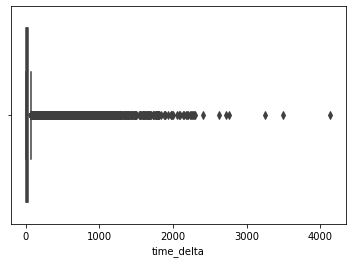

In [106]:
4138/60
sns.boxplot(df_temp.time_delta)

In [103]:
df_temp.time_delta.sort_values(ascending=False)[0:30]

179171    4138
36456     3490
535796    3250
496378    2757
281346    2727
193529    2621
523979    2408
578678    2304
179173    2290
457016    2265
438114    2258
219055    2243
520917    2235
576355    2210
482860    2195
547564    2181
576363    2155
518490    2135
283789    2101
131992    2087
459306    2052
491193    1996
234978    1989
588374    1976
260528    1973
216593    1932
556630    1892
140560    1891
199493    1888
420875    1884
Name: time_delta, dtype: int64

In [118]:
df_temp.time_delta.value_counts()[0:50]

1     30804
2     29435
3     26993
4     25624
5     23981
6     22184
7     21459
8     19488
9     18731
10    17281
0     17192
11    16252
12    15530
13    14382
14    13706
15    12926
16    12118
17    11319
18    10853
19    10363
20     9763
21     9127
22     8912
23     8246
24     7928
25     7256
26     7006
27     6625
28     6273
29     6048
30     5654
31     5339
32     5123
33     4808
34     4642
35     4459
36     4200
37     3975
38     3779
39     3661
40     3465
41     3331
42     3187
43     3005
45     2817
44     2809
47     2504
46     2498
48     2407
49     2289
Name: time_delta, dtype: int64

In [119]:
df_temp[df_temp.time_delta==1].shape

(30804, 11)

In [100]:
df_temp.describe()

,TransactionDT,time_delta,days_7,time_days_7,time_days_14,time_days_21,time_days_30,time_days_45,time_days_60,time_days_90,time_days_12
count,5.905400e+05,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000
mean,7.372311e+06,26.627715,3.803959,3.803959,1.901980,1.267986,0.887591,0.591727,0.443795,0.295864,0.072953
std,4.617224e+06,59.299048,8.471293,8.471293,4.235646,2.823764,1.976635,1.317757,0.988317,0.658878,0.162463
min,8.640000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.027058e+06,5.000000,0.714286,0.714286,0.357143,0.238095,0.166667,0.111111,0.083333,0.055556,0.013699
50%,7.306528e+06,13.000000,1.857143,1.857143,0.928571,0.619048,0.433333,0.288889,0.216667,0.144444,0.035616
75%,1.124662e+07,29.000000,4.142857,4.142857,2.071429,1.380952,0.966667,0.644444,0.483333,0.322222,0.079452
max,1.581113e+07,4138.000000,591.142857,591.142857,295.571429,197.047619,137.933333,91.955556,68.966667,45.977778,11.336986


In [116]:
print(4138.000000/365, 'years')
print(4138.000000/24, 'days')
# print(4138.000000/1, 'hour')
print(4138.000000/60, 'minutes')
print(4138.000000/3600, 'hours')

# print(4138.000000/3600, 'hours')
# print(4138.000000/60, 'minutes')
# Looking at the max value... 
# there is no way to discern who is what credit card holder. We know each transaction is unique and has some
# kind of 

11.336986301369864 years
172.41666666666666 days
68.96666666666667 minutes
1.1494444444444445 hours


In [74]:
pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/df_scores.csv') # comment out

In [ ]:
# # it reads the csv, creates a dataframe, then appends the results, then saves over the old version and keeps
# # a record of all columns in the tested dataframe.

# X = df_features.drop(col_target, axis=1)
# X = X.drop(col_id, axis=1)
# y = df_features[col_target]

# # we want to test a feature for feature engineering... we must 

# for col_original, col_new in zip(list_col, fe.list_new_feat):
#     print(col_original, col_new)
#     X[col_new] = fe.df_feat[col_new]
#     X = X.drop(col_original, axis=1)

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
#     start_time = time.time()

#     sm = SMOTE(random_state=42, ratio=1.0, n_jobs=-1) # SMOTE
#     X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
    
#     model_lr_pca_sm = LogisticRegression(random_state=42, n_jobs=-1) # logistic regression
#     model_lr_pca_sm.fit(X_train_res, y_train_res)
    
#     y_pred = model_lr_pca_sm.predict(X_test)     # predict
    
#     elapsed_time = time.time() - start_time
#     print('\nTime elapsed:', elapsed_time / 60)
#     print(confusion_matrix(y_test, y_pred))
#     print(classification_report(y_test, y_pred))
    
# #     X = X.drop(col, axis=1)
#     print(list(X.columns))

In [ ]:
# df_temp = fe.df_feat[['TransactionDT']]
# df_temp['time_delta'] = 0
# len_df_temp = df_temp.shape[0]
# for i in range(1,len(df_temp['TransactionDT'][0:len_df_temp])):
#     val_time_1 = df_temp.loc[i - 1, 'TransactionDT']
#     val_time_2 = df_temp.loc[i, 'TransactionDT']
#     val_time_delta = val_time_2 - val_time_1
#     df_temp.loc[i, 'time_delta'] = val_time_delta

In [ ]:
# fe.df_feat = fe.df_feat.drop(['time_delta_fe'],axis=1)
# df_temp.columns

In [ ]:
# fe.df_feat['time_delta'] = df_temp['time_delta']
# fe.df_feat['time_delta_week'] = df_temp['time_delta']/7
# fe.df_feat['time_delta_month'] = df_temp['time_delta']/30
# fe.df_feat

In [ ]:
# fe.df_feat = fe.df_feat.drop(['time_delta_fe','time_delta_fe_week'],axis=1)
# list(fe.df_feat.columns)

In [ ]:
# fe.df_feat['TransactionAmt'] = df_features['TransactionAmt']
# list(fe.df_feat)
# fe.list_new_feat

In [ ]:
# fe.df_feat = fe.df_feat.drop(['time_delta_fe','addr1_fe'],axis=1)
# list(fe.df_feat.columns)

In [ ]:
# KEEP
# val_aggreg = 'TransactionAmt'
# list_col = ['card2', 'C4', 'C1', 'V317', 'ProductCD', 'V294', 'V279', 'C14', 'card6', 'V306', 'V69']
# fe.aggregate_features(list_col, val_aggreg)
# list(fe.df_feat.columns)

In [95]:
##### implement into feature engineering class. days lapsed
df_temp = fe.df_feat[['TransactionDT']]
df_temp['time_delta'] = 0
len_df_temp = df_temp.shape[0]
for i in range(1,len(df_temp['TransactionDT'][0:len_df_temp])):
    val_time_1 = df_temp.loc[i - 1, 'TransactionDT']
    val_time_2 = df_temp.loc[i, 'TransactionDT']
    val_time_delta = val_time_2 - val_time_1
    df_temp.loc[i, 'time_delta'] = val_time_delta

In [ ]:
# we created the method to 
# test keeping the old feature then scoring... run this twice. 

In [ ]:
# df_temp.columns

In [ ]:
# df_temp.time_delta.value_counts()

In [ ]:
# df_temp[df_temp.time_delta==1].shape

In [ ]:
# df_temp[(df_temp.time_delta==1) & (df_temp.isFraud==0)].shape

In [ ]:
# df_temp[(df_temp.time_delta==1) & (df_temp.isFraud==1)].shape[0]/df_temp[(df_temp.time_delta==1) & (df_temp.isFraud==0)].shape[0]

In [ ]:
# df_temp
# we need to figure out how to bin transactions based 
# Is there a relationship between isFraud and time_delta

In [ ]:
# df_temp['TransactionAmt'] = fe.df_feat['TransactionAmt']
# df_temp['isFraud'] = fe.df_feat['isFraud']
# df_temp[df_temp.isFraud==1][0:60] # how do we bin these? 
# df_temp2 = fe.df_feat.copy()
# df_temp2['time_delta'] = df_temp['time_delta']
# df_temp2.groupby('isFraud').mean()
# # we can do based on transactionamt and time delta as well as 

In [ ]:
# run through the aggregation of date, every 7 days, calculate the possibility of fraud for the average week
# then do the average month
# this would mean that we need to order the dataset dates in some kind of order of 7
# create column that expresses days lapsed... just focus on that for a bit. Days lapsed between each transaction
######################################################

In [ ]:
# list_timedelta_isfraud = ['D1','D2','D3','D4','D10','D11','D15','isFraud']#, 'TransactionAmt']
# df_temp = fe.df_feat[list_timedelta_isfraud].groupby('isFraud').mean()
# df_temp

In [ ]:
# look into this strategy 
# so we take each D and aggregate it to C4 for only columns that have fraud, then for columns that dont have
# fraud, then we map those values to each that dont have fraud and those that do... 

In [ ]:
# # append D1 value based on if its fraud or not. Create a dictionary for each column, then map it
# for col in ['D1']:
#     df_temp = fe.df_feat[[col, 'isFraud']].groupby('isFraud').mean()
#     dict_col = df_temp.to_dict()
#     fe.df_feat[col + '_fe'] = 
#     # this might not work because we cant assign some random value that has a row that is fraud and expect

In [ ]:
# list_test = ['C2', 'D1',
#  'D2',
#  'D3',
#  'D4',
#  'D10',
#  'D11',
#  'D15', 'isFraud']
# df_not_fraud = fe.df_feat[fe.df_feat.isFraud==0]
# df_fraud = fe.df_feat[fe.df_feat.isFraud==1]

In [ ]:
# # aggregate based on D1 and isFraud
# df_test = fe.df_feat[['C2', 'isFraud']].groupby('C2').mean()
# # df_test = fraud_summ.mean() 
# # df_test.isFraud.value_counts()
# dict_c2_isfraud = df_test.to_dict()['isFraud']
# fe.df_feat['C2_fe'] = fe.df_feat['C2'].map(dict_c2_isfraud)
# ###############################################################

In [ ]:
# KEEP
# class Results():
#     def __init__(self):
#         self.model_lr_results = pd.DataFrame()
#         self.model_recall = []
#         self.model_precision = []
# #         self.model_auc_score = []
        
#     def _score(self, y_true, y_pred):
#         self.model_recall.append(recall_score(y_true, y_pred))
#         self.model_precision.append(precision_score(y_true, y_pred))
#         self._create_series()
# #         self.model_auc_score.append(roc_auc_score(y_true, y_pred[:,1]))

#     def _create_series(self):
#         model_recall = pd.Series(self.model_recall, name='recall')
#         model_precision = pd.Series(self.model_precision, name='precision')
# #         model_auc_score = pd.Series(self.model_auc_score, name='auc_score')
#         model_results_final = pd.concat([model_recall, model_precision],axis=1)
#         return model_results_final

In [ ]:
# X = df_features.drop(col_target, axis=1)
# X = X.drop(col_id, axis=1)
# y = df_features[col_target]

# X = fe.df_feat.drop(col_target, axis=1)
# X = X.drop(col_id, axis=1)
# y = df_features[col_target]
# list(X.columns)

In [ ]:
# KEEP
# ### PCA + SMOTE testing algorithm ###
# import time
# start_time = time.time()
# # applying PCA
# scaled_X = StandardScaler().fit_transform(X)
# # pca = PCA(n_components=250)
# pca = PCA()
# pcomponents = pca.fit_transform(scaled_X)
# X_pca = pd.DataFrame(data=pcomponents)

# X_train2, X_test2, y_train2, y_test2 = train_test_split(X_pca, y, test_size=0.1, random_state=42)

# # applying SMOTE
# sm = SMOTE(random_state=42, ratio=1.0, n_jobs=-1)
# X_train_res, y_train_res = sm.fit_sample(X_train2, y_train2)

# # fit logistic regression
# model_lr_pca_sm = LogisticRegression(random_state=42, n_jobs=-1)
# model_lr_pca_sm.fit(X_train_res, y_train_res)
# # predict
# y_pred = model_lr_pca_sm.predict(X_train2)
# # time
# elapsed_time = time.time() - start_time
# print('\nTime elapsed:', elapsed_time / 60)
# print(confusion_matrix(y_train2, y_pred))
# print(classification_report(y_train2, y_pred))

In [ ]:
# X = df_features.drop(col_target, axis=1)
# X = X.drop(col_id, axis=1)
# y = df_features[col_target]
# list(X.columns[275:])

In [ ]:
# X = fe.df_feat.drop(col_target, axis=1)
# X = X.drop(col_id, axis=1)
# y = df_features[col_target]
# list(X.columnsa[275:])

In [ ]:
# list(X.columns)

#### LogisticRegression Base

In [ ]:
# NEXT, get our score working properly again... What did we do to score 
# LogisticRegression Base
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
start_time = time.time()
# applying SMOTE
sm = SMOTE(random_state=42, ratio=1.0, n_jobs=-1)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
# fit logistic regression
model_lr_pca_sm = LogisticRegression(random_state=42, n_jobs=-1)
model_lr_pca_sm.fit(X_train_res, y_train_res)
# predict
y_pred = model_lr_pca_sm.predict(X_test)
# time
elapsed_time = time.time() - start_time
print('\nTime elapsed:', elapsed_time / 60)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# BASE SCORE
# Time elapsed: 4.251827295621236
# [[33985 22960]
#  [  601  1508]]
#               precision    recall  f1-score   support

#            0       0.98      0.60      0.74     56945
#            1       0.06      0.72      0.11      2109

#     accuracy                           0.60     59054
#    macro avg       0.52      0.66      0.43     59054
# weighted avg       0.95      0.60      0.72     59054

# RESULT: addr1_fe only

# RESULT: time_delta_fe, addr1
# Time elapsed: 5.163579479853312
# [[26551 30394]
#  [  363  1746]]
#               precision    recall  f1-score   support

#            0       0.99      0.47      0.63     56945
#            1       0.05      0.83      0.10      2109

#     accuracy                           0.48     59054
#    macro avg       0.52      0.65      0.37     59054
# weighted avg       0.95      0.48      0.61     59054

# RESULT: time_delta_fe, time_delta_week_fe
# Time elapsed: 3.142271514733632
# [[32540 24405]
#  [  560  1549]]
#               precision    recall  f1-score   support

#            0       0.98      0.57      0.72     56945
#            1       0.06      0.73      0.11      2109

#     accuracy                           0.58     59054
#    macro avg       0.52      0.65      0.42     59054
# weighted avg       0.95      0.58      0.70     59054


# RESULT: created time_delta_fe
# Time elapsed: 3.1532896359761557
# [[26260 30685]
#  [  359  1750]]
#               precision    recall  f1-score   support

#            0       0.99      0.46      0.63     56945
#            1       0.05      0.83      0.10      2109

#     accuracy                           0.47     59054
#    macro avg       0.52      0.65      0.36     59054
# weighted avg       0.95      0.47      0.61     59054

# RESULT: time_delta_fe only. dropping addr1_fe
# Time elapsed: 6.11533077955246
# [[26893 30052]
#  [  365  1744]]
#               precision    recall  f1-score   support

#            0       0.99      0.47      0.64     56945
#            1       0.05      0.83      0.10      2109

#     accuracy                           0.48     59054
#    macro avg       0.52      0.65      0.37     59054
# weighted avg       0.95      0.48      0.62     59054

In [ ]:
fe.list_new_feat
'TransactionAmt_fe', 'card1_fe', 'card2_fe','card3_fe', 'card5_fe', 'addr1_fe', 'addr2_fe'

#### LogisticRegression feature testing

In [ ]:
X = df_features.drop(col_target, axis=1)
X = X.drop(col_id, axis=1)
y = df_features[col_target]

In [ ]:
# Testing 'TransactionAmt_fe', 'card1_fe', 'card2_fe','card3_fe', 'card5_fe', 'addr1_fe', 'addr2_fe'
# Good: addr2_fe, 
# Bad: TransactionAmt_fe, card1_fe, card2_fe, card3_fe, card5_fe
# build a function that after a feature is created, you then have it test the feature and provide you results.. 

for col_original, col_new in zip(list_col, fe.list_new_feat):
    print(col_original, col_new)
    X[col_new] = fe.df_feat[col_new]
    X = X.drop(col_original, axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    start_time = time.time()
    sm = SMOTE(random_state=42, ratio=1.0, n_jobs=-1) # SMOTE
    X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
    model_lr_pca_sm = LogisticRegression(random_state=42, n_jobs=-1) # logistic regression
    model_lr_pca_sm.fit(X_train_res, y_train_res)
    y_pred = model_lr_pca_sm.predict(X_test)     # predict
    elapsed_time = time.time() - start_time
    print('\nTime elapsed:', elapsed_time / 60)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
#     X = X.drop(col, axis=1)
    print(list(X.columns))
# RESULTS: Base: 601

# RESULTS

In [ ]:
# # NEXT, TESTING groupby on C2 and isFraud...test other columns too.. specifically, D1, D2, etc. 
# # consider creating a rolling 7 day period for time between transactions and aggregating isFraud to estimate
# # the amount spent that week against the probability that fraud happened.

# # good fe: C2_fe, card2_fe, V294_fe, V317_fe, V279_fe, V306_fe
# # bad fe: C1_fe, ProductCD_fe, V294_fe, C14_fe, card6_fe, V69_fe
# for col in list_col_fe:
#     X[col] = fe.df_feat[col]    
#     print(col)
    
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
#     start_time = time.time()
#     sm = SMOTE(random_state=42, ratio=1.0, n_jobs=-1) # SMOTE
#     X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
#     model_lr_pca_sm = LogisticRegression(random_state=42, n_jobs=-1) # logistic regression
#     model_lr_pca_sm.fit(X_train_res, y_train_res)
#     y_pred = model_lr_pca_sm.predict(X_test)     # predict
#     elapsed_time = time.time() - start_time
#     print('\nTime elapsed:', elapsed_time / 60)
#     print(confusion_matrix(y_test, y_pred))
#     print(classification_report(y_test, y_pred))
#     X = X.drop(col, axis=1)
    
# # good: C2_fe, 
# # not good: card2_fe, C4_fe 

In [ ]:
# prior information 
# C2_fe

# Time elapsed: 6.717598664760589
# [[33735 23210]
#  [  595  1514]]
#               precision    recall  f1-score   support

#            0       0.98      0.59      0.74     56945
#            1       0.06      0.72      0.11      2109

#     accuracy                           0.60     59054
#    macro avg       0.52      0.66      0.43     59054
# weighted avg       0.95      0.60      0.72     59054

# card2_fe

# Time elapsed: 7.546754765510559
# [[35200 21745]
#  [  649  1460]]
#               precision    recall  f1-score   support

#            0       0.98      0.62      0.76     56945
#            1       0.06      0.69      0.12      2109

#     accuracy                           0.62     59054
#    macro avg       0.52      0.66      0.44     59054
# weighted avg       0.95      0.62      0.74     59054

# C4_fe

# Time elapsed: 5.034457282225291
# [[36521 20424]
#  [  602  1507]]
#               precision    recall  f1-score   support

#            0       0.98      0.64      0.78     56945
#            1       0.07      0.71      0.13      2109

#     accuracy                           0.64     59054
#    macro avg       0.53      0.68      0.45     59054
# weighted avg       0.95      0.64      0.75     59054

# C1_fe

# Time elapsed: 5.847904968261719
# [[40085 16860]
#  [  701  1408]]
#               precision    recall  f1-score   support

#            0       0.98      0.70      0.82     56945
#            1       0.08      0.67      0.14      2109

#     accuracy                           0.70     59054
#    macro avg       0.53      0.69      0.48     59054
# weighted avg       0.95      0.70      0.80     59054

# V317_fe

# Time elapsed: 4.49170538187027
# [[33842 23103]
#  [  583  1526]]
#               precision    recall  f1-score   support

#            0       0.98      0.59      0.74     56945
#            1       0.06      0.72      0.11      2109

#     accuracy                           0.60     59054
#    macro avg       0.52      0.66      0.43     59054
# weighted avg       0.95      0.60      0.72     59054

# ProductCD_fe

# Time elapsed: 5.576840949058533
# [[41354 15591]
#  [  737  1372]]
#               precision    recall  f1-score   support

#            0       0.98      0.73      0.84     56945
#            1       0.08      0.65      0.14      2109

#     accuracy                           0.72     59054
#    macro avg       0.53      0.69      0.49     59054
# weighted avg       0.95      0.72      0.81     59054

# V294_fe

# Time elapsed: 4.640570282936096
# [[37922 19023]
#  [  698  1411]]
#               precision    recall  f1-score   support

#            0       0.98      0.67      0.79     56945
#            1       0.07      0.67      0.13      2109

#     accuracy                           0.67     59054
#    macro avg       0.53      0.67      0.46     59054
# weighted avg       0.95      0.67      0.77     59054

# V279_fe

# Time elapsed: 3.3400171319643657
# [[33443 23502]
#  [  577  1532]]
#               precision    recall  f1-score   support

#            0       0.98      0.59      0.74     56945
#            1       0.06      0.73      0.11      2109

#     accuracy                           0.59     59054
#    macro avg       0.52      0.66      0.42     59054
# weighted avg       0.95      0.59      0.71     59054

# C14_fe

# Time elapsed: 6.974740914503733
# [[35823 21122]
#  [  599  1510]]
#               precision    recall  f1-score   support

#            0       0.98      0.63      0.77     56945
#            1       0.07      0.72      0.12      2109

#     accuracy                           0.63     59054
#    macro avg       0.53      0.67      0.44     59054
# weighted avg       0.95      0.63      0.74     59054

# card6_fe

# Time elapsed: 3.6439321478207907
# [[36705 20240]
#  [  640  1469]]
#               precision    recall  f1-score   support

#            0       0.98      0.64      0.78     56945
#            1       0.07      0.70      0.12      2109

#     accuracy                           0.65     59054
#    macro avg       0.53      0.67      0.45     59054
# weighted avg       0.95      0.65      0.76     59054

# V306_fe

# Time elapsed: 2.792719868818919
# [[34359 22586]
#  [  592  1517]]
#               precision    recall  f1-score   support

#            0       0.98      0.60      0.75     56945
#            1       0.06      0.72      0.12      2109

#     accuracy                           0.61     59054
#    macro avg       0.52      0.66      0.43     59054
# weighted avg       0.95      0.61      0.73     59054

# V69_fe

# Time elapsed: 5.5301028688748675
# [[39833 17112]
#  [  694  1415]]
#               precision    recall  f1-score   support

#            0       0.98      0.70      0.82     56945
#            1       0.08      0.67      0.14      2109

#     accuracy                           0.70     59054
#    macro avg       0.53      0.69      0.48     59054
# weighted avg       0.95      0.70      0.79     59054

In [ ]:
# X = X.drop('card2_fe',axis=1)
list(X.columns)

In [ ]:
# decision tree
for col in list_col_fe:
    X[col] = fe.df_feat[col]    
    print(col)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    start_time = time.time()
    # SMOTE
    sm = SMOTE(random_state=42, ratio=1.0, n_jobs=-1)
    X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
    # fit decision tree
    model_dt_pca_smote = DecisionTreeClassifier(random_state=42)
    model_dt_pca_smote.fit(X_train_res, y_train_res)
    # predict
    y_pred = model_dt_pca_smote.predict(X_train)
    # time
    elapsed_time = time.time() - start_time
    print('\nTime elapsed:', elapsed_time / 60)
    print(confusion_matrix(y_train, y_pred))
    print(classification_report(y_train, y_pred))
    X = X.drop(col, axis=1)
    elapsed_time = time.time() - start_time
    print('\nTime elapsed:', elapsed_time / 60)

In [ ]:
# decision tree
for col in list_col_fe:
    X[col] = fe.df_feat[col]    
    print(col)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    start_time = time.time()
    # applying SMOTE
    sm = SMOTE(random_state=42, ratio=1.0, n_jobs=-1)
    X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
    # fit decision tree
    model_dt_pca_smote = DecisionTreeClassifier(random_state=42)
    model_dt_pca_smote.fit(X_train_res, y_train_res)
    # predict
    y_pred = model_dt_pca_smote.predict(X_test)
    # time
    elapsed_time = time.time() - start_time
    print('\nTime elapsed:', elapsed_time / 60)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    X = X.drop(col, axis=1)
    elapsed_time = time.time() - start_time
    print('\nTime elapsed:', elapsed_time / 60)

In [ ]:
list(X.columns)

In [ ]:
# DecisionTree Base
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
start_time = time.time()
# applying SMOTE
sm = SMOTE(random_state=42, ratio=1.0, n_jobs=-1)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
# fit decision tree
model_dt_pca_smote = DecisionTreeClassifier(random_state=42)
model_dt_pca_smote.fit(X_train_res, y_train_res)
# predict
y_pred = model_dt_pca_smote.predict(X_test)
# time
elapsed_time = time.time() - start_time
print('\nTime elapsed:', elapsed_time / 60)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
elapsed_time = time.time() - start_time
print('\nTime elapsed:', elapsed_time / 60)

# [[55791  1154]
#  [  941  1168]]
#               precision    recall  f1-score   support

#            0       0.98      0.98      0.98     56945
#            1       0.50      0.55      0.53      2109

#     accuracy                           0.96     59054
#    macro avg       0.74      0.77      0.75     59054
# weighted avg       0.97      0.96      0.97     59054


# Time elapsed: 8.485406096776327

In [ ]:
# # fit logistic regression
# model_lr_pca_sm = LogisticRegression(random_state=42, n_jobs=-1)
# model_lr_pca_sm.fit(X_train_res, y_train_res)
# # predict
# y_pred = model_lr_pca_sm.predict(X_train2)
# # time
# elapsed_time = time.time() - start_time
# print('\nTime elapsed:', elapsed_time / 60)
# print(confusion_matrix(y_train2, y_pred))
# print(classification_report(y_train2, y_pred))

In [ ]:
# RESULT: C4_fe with TransactionAmt

# RESULT: Base Score, smote only, no pca
# [[245073 267859]
#  [  3447  15107]]
#               precision    recall  f1-score   support

#            0       0.99      0.48      0.64    512932
#            1       0.05      0.81      0.10     18554

#     accuracy                           0.49    531486
#    macro avg       0.52      0.65      0.37    531486
# weighted avg       0.95      0.49      0.62    531486

# Scores below reflect _fe's
# RESULTS: drop card6_fe
# Time elapsed: 3.520830734570821
# [[361114 151818]
#  [  4823  13731]]
#               precision    recall  f1-score   support

#            0       0.99      0.70      0.82    512932
#            1       0.08      0.74      0.15     18554

#     accuracy                           0.71    531486
#    macro avg       0.53      0.72      0.49    531486
# weighted avg       0.96      0.71      0.80    531486

# RESULTS: card6_fe 
# Time elapsed: 3.569287049770355
# [[362083 150849]
#  [  4745  13809]]
#               precision    recall  f1-score   support

#            0       0.99      0.71      0.82    512932
#            1       0.08      0.74      0.15     18554

#     accuracy                           0.71    531486
#    macro avg       0.54      0.73      0.49    531486
# weighted avg       0.96      0.71      0.80    531486

# RESULTS: dropped features and used PCA, worstened score
# [[413977  98955]
#  [  4747  13807]]
#               precision    recall  f1-score   support

#            0       0.99      0.81      0.89    512932
#            1       0.12      0.74      0.21     18554

#     accuracy                           0.80    531486
#    macro avg       0.56      0.78      0.55    531486
# weighted avg       0.96      0.80      0.87    531486

# RESULTS: drop low ranking features found in decision tree
# [[329812 183120]
#  [  4810  13744]]
#               precision    recall  f1-score   support

#            0       0.99      0.64      0.78    512932
#            1       0.07      0.74      0.13     18554

#     accuracy                           0.65    531486
#    macro avg       0.53      0.69      0.45    531486
# weighted avg       0.95      0.65      0.76    531486

# RESULTS: without PCA
# [[298715 214217]
#  [  3509  15045]]
#               precision    recall  f1-score   support

#            0       0.99      0.58      0.73    512932
#            1       0.07      0.81      0.12     18554

#     accuracy                           0.59    531486
#    macro avg       0.53      0.70      0.43    531486
# weighted avg       0.96      0.59      0.71    531486

# RESULTS: keep ohe for email and create p email feature calculate email domain fraud feature
# [[434421  78511]
#  [  4429  14125]]
#               precision    recall  f1-score   support

#            0       0.99      0.85      0.91    512932
#            1       0.15      0.76      0.25     18554

#     accuracy                           0.84    531486
#    macro avg       0.57      0.80      0.58    531486
# weighted avg       0.96      0.84      0.89    531486

# RESULTS: with new feature, try dropping ohe p_email and test
# [[435499  77433]
#  [  4539  14015]]
#               precision    recall  f1-score   support

#            0       0.99      0.85      0.91    512932
#            1       0.15      0.76      0.25     18554

#     accuracy                           0.85    531486
#    macro avg       0.57      0.80      0.58    531486
# weighted avg       0.96      0.85      0.89    531486

# RESULTS: cut FP rate quite a bit. fixing fraud perc calculation by doing fraud/non fraud for each value in each column
# [[434423  78509]
#  [  4430  14124]]
#               precision    recall  f1-score   support

#            0       0.99      0.85      0.91    512932
#            1       0.15      0.76      0.25     18554

#     accuracy                           0.84    531486
#    macro avg       0.57      0.80      0.58    531486
# weighted avg       0.96      0.84      0.89    531486


# RESULTS: adding 60 for one hot encoding
# [[403339 109593]
#  [  4393  14161]]
#               precision    recall  f1-score   support

#            0       0.99      0.79      0.88    512932
#            1       0.11      0.76      0.20     18554

#     accuracy                           0.79    531486
#    macro avg       0.55      0.77      0.54    531486
# weighted avg       0.96      0.79      0.85    531486

# RESULTS: fe for 'addr1', 'addr2', 'card1', 'card2', 'card3', 'card5'
# [[397116 115816]
#  [  4490  14064]]
#               precision    recall  f1-score   support

#            0       0.99      0.77      0.87    512932
#            1       0.11      0.76      0.19     18554

#     accuracy                           0.77    531486
#    macro avg       0.55      0.77      0.53    531486
# weighted avg       0.96      0.77      0.84    531486

# RESULTS: only addr6. Creating ratio ranking of higher risk areas for fraud. 
# [[396866 116066]
#  [  4534  14020]]
#               precision    recall  f1-score   support

#            0       0.99      0.77      0.87    512932
#            1       0.11      0.76      0.19     18554

#     accuracy                           0.77    531486
#    macro avg       0.55      0.76      0.53    531486
# weighted avg       0.96      0.77      0.84    531486

# NEXT, test creating iqr range instead of percentage values, instead of what we did
# with addr5, then create one for addr2, then create an addr7 based on interaction with addr2. 



# RESULTS: only addr5. testing mapping percentage values transformed..
# [[396898 116034]
#  [  4535  14019]]
#               precision    recall  f1-score   support

#            0       0.99      0.77      0.87    512932
#            1       0.11      0.76      0.19     18554

#     accuracy                           0.77    531486
#    macro avg       0.55      0.76      0.53    531486
# weighted avg       0.96      0.77      0.84    531486

# RESULTS: with only addr3, addr4
# [[396868 116064]
#  [  4544  14010]]
#               precision    recall  f1-score   support

#            0       0.99      0.77      0.87    512932
#            1       0.11      0.76      0.19     18554

#     accuracy                           0.77    531486
#    macro avg       0.55      0.76      0.53    531486
# weighted avg       0.96      0.77      0.84    531486

# RESULTS: w/o addr1, addr2, addr3, addr4
# [[396629 116303]
#  [  4545  14009]]

#               precision    recall  f1-score   support

#            0       0.99      0.77      0.87    512932
#            1       0.11      0.76      0.19     18554

#     accuracy                           0.77    531486
#    macro avg       0.55      0.76      0.53    531486
# weighted avg       0.96      0.77      0.84    531486

# RESULTS: with only addr1, addr2
# [[396803 116129]
#  [  4555  13999]]
#               precision    recall  f1-score   support

#            0       0.99      0.77      0.87    512932
#            1       0.11      0.75      0.19     18554

#     accuracy                           0.77    531486
#    macro avg       0.55      0.76      0.53    531486
# weighted avg       0.96      0.77      0.84    531486

# RESULTS: with addr1, addf2, addr3, addr4
# [[396877 116055]
#  [  4549  14005]]
#               precision    recall  f1-score   support

#            0       0.99      0.77      0.87    512932
#            1       0.11      0.75      0.19     18554

#     accuracy                           0.77    531486
#    macro avg       0.55      0.76      0.53    531486
# weighted avg       0.96      0.77      0.84    531486

### Decision Tree - SMOTE only

In [ ]:
# X = fe.df_feat.drop(col_target, axis=1)
# X = X.drop(col_id, axis=1)
# y = df_features[col_target]
# list(X.columns)

In [ ]:
# decision tree smote only (pca commented out)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.1, random_state=42)

# # applying PCA
# scaled_X = StandardScaler().fit_transform(X)
# # pca = PCA(n_components=250)
# pca = PCA()
# pcomponents = pca.fit_transform(scaled_X)
# X_pca = pd.DataFrame(data=pcomponents)
# X_train2, X_test2, y_train2, y_test2 = train_test_split(X_pca, y, test_size=0.1, random_state=42)

start_time = time.time()
# applying SMOTE
sm = SMOTE(random_state=42, ratio=1.0, n_jobs=-1)
X_train_res, y_train_res = sm.fit_sample(X_train2, y_train2)

model_dt_pca_smote = DecisionTreeClassifier(random_state=42)
model_dt_pca_smote.fit(X_train_res, y_train_res)
elapsed_time = time.time() - start_time
print('\nTime elapsed:', elapsed_time / 60)

# Feature importance
col_name = pd.Series(X.columns, name='col')
col_feat_rank = pd.Series(model_dt_pca_smote.feature_importances_, name='feat_rank')
df_feat_rank = pd.concat([col_name, col_feat_rank], axis=1).sort_values('feat_rank', ascending=False)

plt.figure(figsize=(5,6))
sns.barplot(df_feat_rank.feat_rank[0:10], df_feat_rank.col[0:10], palette='Blues_d')
plt.title('Feature Importance')
plt.show()
df_feat_rank[0:40]

In [ ]:
# # EDA on C4 and TransactionAmt
# df_temp = fe.df_feat

# sns.lineplot(x='C4', y='TransactionAmt', data=df_temp)
# plt.title('C4 versus Transaction Amount')
# plt.show()

# sns.scatterplot(x='C4', y='TransactionAmt', hue='isFraud', data=df_temp)
# plt.title('C4 versus Transaction Amount')
# plt.show()

In [ ]:
# the type of card is highly correllated with debit, credit, etc. figure out which feature to create. 

In [ ]:
# y_pred = model_lr_pca_sm.predict(X_pca)

# cross validation
# result = cross_val_score(model_lr_pca_sm, X_train2, y_train2, cv=10, n_jobs=-1, scoring='recall_score')
# result.mean()

In [ ]:
# notes, do we need to visualize our results?? We need to look at our confusion matrix
# and decide how to improve our results from here... Test and see what happens if we 
# increase our principal components... test removing columns, adding columns, imputing
# certain columns all together. 

# test imputing 500 or less for ohe. Then test dropping card1 due to its number
# of unique values that would make our data very high dimensional. We can try only ohe for
# the entire dataset to see how our model performs over all... Though.. it will likely run 
# out of memory and crash. 

# ALSO test probabilities on logisticregression


### Predict Proba

In [ ]:
# %matplotlib inline
# plt.rcParams['font.size'] = 14

# y_pred_prob = model_lr_pca.predict_proba(X_pca)
# plt.hist(y_pred_prob[:,1], bins=8)
# plt.xlim(0,1)
# plt.title("Histogram of Probability of Fraud")
# plt.xlabel("Predicted probability of Fraud")
# plt.ylabel("Frequency")

# y_pred_prob = model_lr_pca.predict_proba(X_pca)
# y_pred_class = binarize(y_pred_prob, 0.5)[:,1]

# print(confusion_matrix(y, y_pred_class))
# print(classification_report(y, y_pred_class))

# fpr, tpr, thresholds = roc_curve(y, y_pred_prob[:,1])
# plt.plot(fpr, tpr)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.title("ROC curve for fraud detection classifier")
# plt.xlabel("False Positive Rate (1 - Specificity)")
# plt.ylabel("True Positive Rate (Sensitivity)")
# plt.grid(True)
# plt.show()

In [ ]:
# def evaluate_threshold(threshold):
#     print("Sensitivity:", tpr[thresholds > threshold][-1])
#     print("Specificity:", 1 - fpr[thresholds > threshold][-1],'\n')
    
# evaluate_threshold(.5)
# evaluate_threshold(.2)
# evaluate_threshold(.1)

# print(roc_auc_score(y, y_pred_prob[:,1]))

In [ ]:
# y_pred_actual = model_lr_pca.predict(X_test2) # actual prediction test data set
# print('y_pred_actual on test set\n')
# print(y_pred_actual[0:10])
# print(confusion_matrix(y_test2, y_pred_actual))
# print(classification_report(y_test2, y_pred_actual))

# print('y_pred_proba\n')
# y_pred_proba = model_lr_pca.predict_proba(X_test2)
# y_pred_class = binarize(y_pred_proba, 0.5)[:,1]
# print(y_pred_class[0:10])
# print(confusion_matrix(y_test2, y_pred_class))
# print(classification_report(y_test2, y_pred_class))

In [ ]:
# y_pred_actual = model_lr_pca.predict(X_pca) # actual full data set
# print('Logistic Regression')
# print('y_pred_actual full data set\n')
# print(y_pred_actual[0:10])
# print(confusion_matrix(y, y_pred_actual))
# print(classification_report(y, y_pred_actual))

# print('y_pred_proba full data set\n')
# y_pred_proba = model_lr_pca.predict_proba(X_pca)#[:,1]#[0:10]
# y_pred_class = binarize(y_pred_proba, 0.2)[:,1]
# print(y_pred_class[0:10])
# print(confusion_matrix(y, y_pred_class))
# print(classification_report(y, y_pred_class))

In [ ]:
# # predicting on test set w/o PCA
# print("Predicting using Logistic Regression, PCA, SMOTE\n")
# y_pred_pca_sm = model_lr_pca.predict(X_test2)
# # y_pred_test1 = model_lr.predict(X_test1)
# print("Test set:")
# print("Validation results")
# print(model_lr_pca.score(X_test2, y_test2))
# print(recall_score(y_test2, y_pred_pca_sm))
# print("\nConfusion Matrix")
# print(confusion_matrix(y_test2, y_pred_pca_sm))
# print('\nClassification Report:\n')
# print(classification_report(y_test2, y_pred_pca_sm))

# # predicting on original dataset
# print("Whole dataset:")
# y_pred_pca_sm_whole = model_lr_pca.predict(X_pca)
# print("\nTest Results")
# print(model_lr_pca.score(X_pca, y))
# print(recall_score(y, y_pred_pca_sm_whole))
# print("\nConfusion Matrix")
# print(confusion_matrix(y, y_pred_pca_sm_whole))
# print('\nClassification Report:\n')
# print(classification_report(y, y_pred_pca_sm_whole))

In [ ]:
# print('dataframe length: ' + str(df_features.shape[0]))
# print('TransactionDT unique: ' + str(len(df_features.TransactionDT.unique())))
# print('is not fraud: ' + str(df_features[df_features.isFraud==0].shape[0]))
# print('is fraud: ' + str(df_features[df_features.isFraud==1].shape[0]))

In [ ]:
# # KEEP
# fig = plt.figure(figsize=(15,4))
# df_temp = df_features
# sns.kdeplot(df_temp.loc[(df_temp.isFraud==0), 'TransactionDT'], color='b', shade=True, label='Not Fraud')
# sns.kdeplot(df_temp.loc[(df_temp.isFraud==1), 'TransactionDT'], color='r', shade=True, label='Fraud')
# plt.title('Transaction Date Versus Fraud')
# plt.show()

In [ ]:
# sns.barplot(x='TransactionDT', y='TransactionDT', hue='isFraud', data=df_features)
# plt.title("Transaction Date Versus Fraud")
# plt.show()

# we want to figure out how to create more features from TransactionDT.. 
# are certain transactions more likely. in general, to be fraudualant around a certain day? 
# we have transactionID yet we dont have the specific card of who it belongs to.. 
# if card1 is the unique identifier... and we did a groupby on fraud.. 
# we have average spent per day as an option... 
# create a feature that is average spent per day for non fraud versus average spent per day for fraud.. 
# what would the describe method reveal for us? 

In [ ]:
# transaction date is the most highly correllated.. another correlation is transaction amount..
# our goal is to create another feature that is highly correllated almost or more than TransactionDT. 
# we want to increase the strength.. What feature can we create that would boost the accuracy...
# what feature can we create that exposes more truth in transactionDT? Would it be a specific date?
# would it be the average amount over each week or month... ? what about a specific dates transaction
# would help us...? We know taking average amounts spent can help us... So if we take monthly spending..
# we can tell the algorithm that during certain months the transaction likelihood of fraud is higher.. 
# we must think up a solution before implementing it, we want to think out the best use of our time.. 
# We might perform EDA to see if specific time chunks do in fact have higher fraud counts.. 

In [ ]:
# list_drop_col_1 = list(df_feat_rank[df_feat_rank.feat_rank < .0015]['col'])
# list_drop_col_2 = list(df_feat_rank[df_feat_rank.feat_rank < .0015]['col'])
# list_drop_col_3 = list(df_feat_rank[df_feat_rank.feat_rank < .01]['col'])

# print(len(list_drop_col_1))
# print(len(list_drop_col_2))
# print(len(list_drop_col_3))

# list_drop_col_1

In [ ]:
# # predicting on test set w/o PCA
# print("Predicting using PCA\n")
# y_pred_pca = model_dt_pca_smote.predict(X_test2)
# # y_pred_test1 = model_lr.predict(X_test1)
# print("Test set:")
# print("Validation results")
# print(model_dt_pca_smote.score(X_test2, y_test2))
# print(recall_score(y_test2, y_pred_pca))
# print("\nConfusion Matrix")
# print(confusion_matrix(y_test2, y_pred_pca))
# print('\nClassification Report:\n')
# print(classification_report(y_test2, y_pred_pca))

# # predicting on original dataset
# print("Whole dataset:")
# y_pred_pca = model_dt_pca_smote.predict(X_pca)
# print("\nTest Results")
# print(model_dt_pca_smote.score(X_pca, y))
# print(recall_score(y, y_pred_pca))
# print("\nConfusion Matrix")
# print(confusion_matrix(y, y_pred_pca))
# print('\nClassification Report:\n')
# print(classification_report(y, y_pred_pca))

In [ ]:
# print("Variance ratio:")
# print(pca.explained_variance_ratio_)
# print("\nPrincipal components explained:")
# pd.DataFrame(pca.components_, columns=list(X.columns), index=('PC1', 'PC2'))

In [ ]:
# # explaining variance
# print('Variance ratio:')
# print(pca.explained_variance_ratio_)
# # interpreting principal components
# print('\nPrincipal components explained:')
# pd.DataFrame(pca.components_, columns=list(X.columns), index=('PC1', 'PC2'))

# # # predicting on original dataset
# # y_pred = clf_lr.predict(X)
# # print("\nTest Results")
# # print(clf_lr.score(X, y))
# # print(recall_score(y, y_pred))
# # print("\nConfusion Matrix")
# # print(confusion_matrix(y, y_pred))
# # print('\nClassification Report:\n')
# # print(classification_report(y, y_pred))

In [ ]:
# scaled_X2 = StandardScaler().fit_transform(X)
# pca3 = PCA(n_components=275)
# pcomponents = pca3.fit_transform(scaled_X2)
# X_pca = pd.DataFrame(data=pcomponents)

## Applying SMOTE

In [ ]:
# # applying SMOTE to train set to correct class imbalance
# sm = SMOTE(random_state=42, ratio = 1.0, n_jobs=-1)
# X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

# # fitting to residuals created by SMOTE
# clf_lr = LogisticRegression(class_weight='balanced', random_state=42)
# clf_lr.fit(X_train_res, y_train_res);

# # predicting on test set
# y_test_pred = clf_lr.predict(X_test)
# print("Validation results")
# print(clf_lr.score(X_test, y_test))
# print(recall_score(y_test, y_test_pred))
# print("\nConfusion Matrix")
# print(confusion_matrix(y_test, y_test_pred))
# print('\nClassification Report:\n')
# print(classification_report(y_test, y_test_pred))

# # predicting on original dataset
# y_pred = clf_lr.predict(X)
# print("\nTest Results")
# print(clf_lr.score(X, y))
# print(recall_score(y, y_pred))
# print("\nConfusion Matrix")
# print(confusion_matrix(y, y_pred))
# print('\nClassification Report:\n')
# print(classification_report(y, y_pred))

In [ ]:
# print("\nConfusion Matrix")
# print(confusion_matrix(y, y_pred))
# print('\nClassification Report:\n')
# print(classification_report(y, y_pred))